In this example, we are analysing the sentiment of tweets with the help of an LSTM neural network. Especially we focus on the training of word embeddings and visualize how the word vectors evolve during training.

From this notebook you may learn:
- How to preprocess texts for classification with neural networks
- Cleaning texts by removing words beginning with speacial characters
- Balancing unequally distributed labels
- Generating animations of the training of word vectors
- Calibrating the predictions

In [ ]:
Name:Anjali Sanjay Rajole                                                 Deep learning 
Roll No : 48 BE IT
    
                                     #Assignment no: 01

In [ ]:
Q.3)Create a deep learning model using keras functional API to perform Twitter data sentiment analysis.

# New Section

In [1]:
import matplotlib as mpl
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from IPython.display import HTML
from base64 import b64encode

In [ ]:
# Die file contains some special characters which are not encoded in common utf-8, but it can
# be loaded with encoding='ISO-8859-1'
Data = pd.read_csv('/content/Twitter_Data.csv')
Data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
# Converting the entire dataset into a NumPy array
Data = Data.to_numpy()

# The positive or negative sentiment is stated in column 0
# The original tweets are stated in column 5
y = Data[:, 0].astype('float32')/4  # Label=0 or 1
X = Data[:, 5]

# Cleansing of the texts
# We remove all user names starting with '@'
# Additionally some special characters in XML format are removed
for i in range(len(X)):
    sentence = " ".join(filter(lambda x: x[0] != '@', X[i].split()))
    sentence = sentence.replace('&ampPOOOOOLL', ' ')  # &
    sentence = sentence.replace('&quotPOOOOOLL', ' ')  # "
    sentence = sentence.replace('&ltPOOOOOLL', ' ')  # <
    sentence = sentence.replace('&gtPOOOOOLL', ' ')  # >
    sentence = sentence.replace('POOOOOLL', ' ')

    X[i] = sentence

AttributeError: ignored

In [ ]:
# Splitting the dataset in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Number of different words in entire dataset: 231920


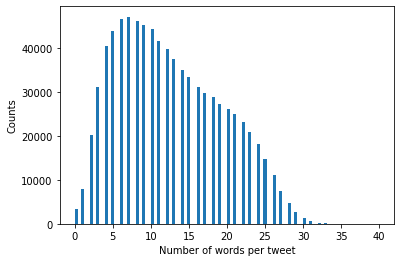

Max number of words per tweet: 40
Shapes von X_train und X_test: (838857, 30) (209715, 30)


In [ ]:
# A tokenizer is used to split the tweets in separate words
# Each word will be replaced by an integer, assigned by a dictionary
# The integers are assigned by the number of occurances of the words, the most often
# occuring word will be assigned the lowest integer 1
# By reducing the num_words to 10000, only the 10000 most often used words will be
# converted to integers when applying the tokenizer
# Filters are used to remove the provided characters
num_words = 10000
tokenizer = keras.preprocessing.text.Tokenizer(
    num_words=num_words,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

# The tokeinzer is fitted on the train data. It counts all existing words
tokenizer.fit_on_texts(X_train)

# Just for interest be print the entire number of different words
print('Number of different words in entire dataset:', len(tokenizer.word_index))

# The tokenizer is applied separately to the train und test data
# We get lists of variable lengths containing the words as integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# We check the distirbutions of the sentence legth
lengths = [len(x) for x in X_train]
plt.hist(lengths, bins=100)
plt.xlabel('Number of words per tweet')
plt.ylabel('Counts')
plt.show()

# Printing the max length of the tweets (it may vary due to random train / test split)
print('Max number of words per tweet:', max(lengths))

# we decide to use a maximum length of 30, with very little information loss
max_length = 30

# With the help of pad_sequences all lists containing the tokens are padded with zeroes
# to a length of 30. Longer lists are cropped to the length of 30
# The lists are automatically converted to NumPy arrays
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     maxlen=max_length, padding='pre')
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                    maxlen=max_length, padding='pre')


print('Shapes von X_train und X_test:', X_train.shape, X_test.shape)

In [ ]:
# For calibration of the model we separate 1000 calibration data equally balanced from the
# test data
num_calib = 1000
calib_pos_indices = np.random.choice(
    (np.argwhere(y_test == 1)).reshape(-1), size=num_calib, replace=False)
calib_neg_indices = np.random.choice(
    (np.argwhere(y_test == 0)).reshape(-1), size=num_calib, replace=False)
y_calib = np.concatenate(
    (y_test[calib_pos_indices], y_test[calib_neg_indices]), axis=0)
X_calib = np.concatenate(
    (X_test[calib_pos_indices], X_test[calib_neg_indices]), axis=0)

X_test = np.delete(X_test, np.concatenate(
    (calib_neg_indices, calib_pos_indices)), axis=0)
y_test = np.delete(y_test, np.concatenate(
    (calib_neg_indices, calib_pos_indices)), axis=0)


# Counting the number of datapoints of each class
# The datasets is quite unbalanced. There are 3 times more negative than positive tweets
len_pos = len(y_train[y_train == 1])
len_neg = len(y_train[y_train == 0])
print('Number of positive tweets:', len_pos)
print('Number of negative tweets:', len_neg)

class_weight = {0: 1, 1: len_neg/len_pos}

Number of positive tweets: 198853
Number of negative tweets: 640004


In [ ]:
word_vector_length = 2

# Number of words of the tokenizer + 1 for the zeroes of the padding
num_words = num_words + 1

model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, word_vector_length,
                                 input_length=max_length, mask_zero=True))
model.add(keras.layers.LSTM(50, return_sequences=False, dropout=0.2,
                            recurrent_dropout=0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()

2022-08-03 10:16:55.385580: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 2)             20002     
_________________________________________________________________
lstm (LSTM)                  (None, 50)                10600     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,653
Trainable params: 30,653
Non-trainable params: 0
_________________________________________________________________


2022-08-03 10:16:55.771332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


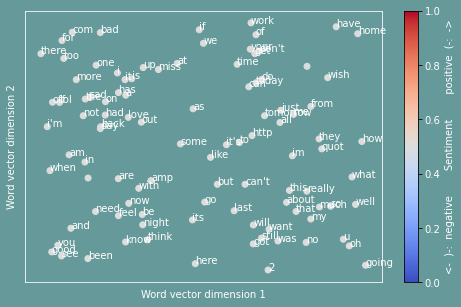

In [ ]:
# Difining some colors
cb = (102/255, 153/255, 153/255)
w = [1, 1, 1]

# Creating a figure with green background
fig, ax = plt.subplots(1, facecolor=cb, figsize=(8, 5))

# Achsen formatieren
ax.set_xlabel('Word vector dimension 1', color=w)
ax.set_ylabel('Word vector dimension 2', color=w)
ax.tick_params(color=w, labelcolor=cb)
ax.set_facecolor(cb)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['bottom'].set_color(w)
ax.spines['top'].set_color(w)
ax.spines['right'].set_color(w)
ax.spines['left'].set_color(w)

# We are plotting the word vectors of the first 100 most common words in the dataset
n = 100

# From the model the embedding layer is extracted and word vectors are predicted
X_embed = model.layers[0](np.arange(n+1))

# Additionally we predict the final sentiment of each word
y_embed = model.predict(np.arange(n+1).reshape(-1, 1))


# Plotting the 1st dimension of the word vectors on the x-axis, 2nd dimension on the
# y-axis and 3rd dimension on the z-axis
# The color of the scatter points represents the sentiment of the word
ax.scatter(X_embed[:, 0], X_embed[:, 1],
           c=y_embed[:, 0], cmap='coolwarm', vmin=0, vmax=1)

# The tokens are converted back with the tokenizers word_index and are added to plot
for u in range(n-1):
    ax.text(X_embed[u+1, 0], X_embed[u+1, 1],
            list(tokenizer.word_index.keys())[u], color=w)

# Finally we add a colorbar to identify the sentiment of each word
PCM = ax.get_children()[0]
cbar = plt.colorbar(PCM, ax=ax)
c_ticks = plt.getp(cbar.ax.axes, 'yticklabels')
plt.setp(c_ticks, color=w)
cbar.set_label(
    '<-  )-:  negative        Sentiment        positive  (-:  ->', color=w)

In [ ]:
# We are creating an animation directly with Matplotlib
# A function is used to create each frame of the video
def animate(i):
    print('Frame:', i)

    # First delete the previous plot
    ax.cla()

    # Set again some properties
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Word vector dimension 1', color=w)
    ax.set_ylabel('Word vector dimension 2', color=w)

    # Plotting the first 100 most common words
    n = 100
    X_embed = model.layers[0](np.arange(n)).numpy()
    y_embed = model.predict(np.arange(n).reshape(-1, 1))

    ax.scatter(X_embed[:, 0], X_embed[:, 1],
               c=y_embed[:, 0], cmap='coolwarm', vmin=0, vmax=1)

    for u in range(n-1):
        ax.text(X_embed[u+1, 0], X_embed[u+1, 1],
                list(tokenizer.word_index.keys())[u], color=w)

    # Training the model a little further
    model.fit(X_train, y_train, class_weight=class_weight,
              epochs=1, batch_size=300,
              steps_per_epoch=int(1+i/27), verbose=2)

    return fig,


# Defining an animation with Matplotlib
# The animation will bebased on the stated figure
# The video contains 270 frames at an interval of 200 ms
# The video shall restart automatically after a delay of 2000 ms
# blit may be used to improve the quality
anim = FuncAnimation(fig, animate, repeat_delay=2000, repeat=True,
                     frames=270, interval=200, blit=True)

# For each animation we create a new filename based on the current date and time
filename = time.strftime('Embedding_animation_' +
                         '%Y_%m_%d-%H_%M_%S' + '.mp4')

# To save the animation an external program is used
# The app FFmpeg is open source and distributed at: https://ffmpeg.org/
! tar xvf ../input/ffmpeg-static-build/ffmpeg-git-amd64-static.tar.xz

FFMPEG_BIN = "/kaggle/working/ffmpeg-git-20191209-amd64-static/ffmpeg"

mpl.rcParams['animation.ffmpeg_path'] = FFMPEG_BIN

# Saving the animation to the hard disc
# The external program FFmpeg-Writer is used at, 20 frames / second
anim.save(filename, writer=animation.FFMpegWriter(fps=20))

Frame: 0
1/1 - 4s - loss: 1.1184 - accuracy: 0.4667
ffmpeg-git-20191209-amd64-static/
ffmpeg-git-20191209-amd64-static/GPLv3.txt
ffmpeg-git-20191209-amd64-static/manpages/
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg-all.txt
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg-scaler.txt
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg-resampler.txt
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg-filters.txt
ffmpeg-git-20191209-amd64-static/manpages/ffprobe.txt
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg-devices.txt
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg-utils.txt
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg-protocols.txt
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg-codecs.txt
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg-bitstream-filters.txt
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg.txt
ffmpeg-git-20191209-amd64-static/manpages/ffmpeg-formats.txt
ffmpeg-git-20191209-amd64-static/ffprobe
ffmpeg-git-20191209-amd64-static/qt-faststart
ffmpeg-git-2019120

In [ ]:
video = open('/kaggle/working/'+filename,'rb').read()
src = 'data:video/mp4;base64,' + b64encode(video).decode()
html = '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
HTML(html)


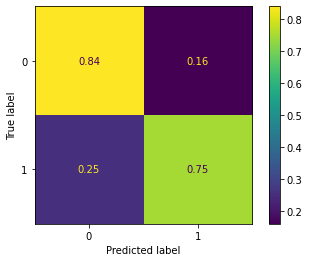

specificity:  0.838557914863641
sensitivity:  0.7460337007162942
recall = sensitivity 0.7460337007162942


In [ ]:
# The model is used to make a prediction of the test data and the results are rounded to 0 or 1
y_pred = model.predict(X_test)
y_pred = np.round(y_pred, 0)

# Creating a confusion matrix with help of the sklearn function
# Due to class_weight used in the fit process, positive and negative tweets can be
# equally well predicted
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# For unbalanced datasets good metrics to describe the performance of the model are
# specificity and the sensitivity (recall)
# The specificity is the accuracy of the test data if their true label is equal to 0
# The upper line of the confusion matrix
# The sensitivity is the accuracy of the test data if their true label is equal to 1
# The lower line of the confusion matrix
[TN, FP], [FN, TP] = cm

specificity = TN/(TN+FP)
sensitivity = TP/(TP+FN)

print('specificity: ', specificity)
print('sensitivity: ', sensitivity)

# Snesitivity is identical to recall score of sklearn
print('recall = sensitivity', recall_score(y_test, y_pred))

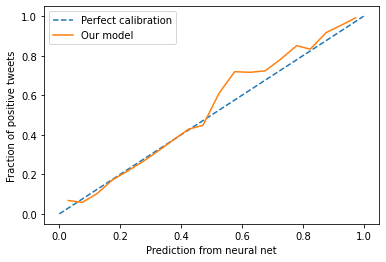

---------------Calibration---------------
Prediction of x_calib before calibration [0.19106534]
Prediction of x_calib after calibration 0.18701286182689197


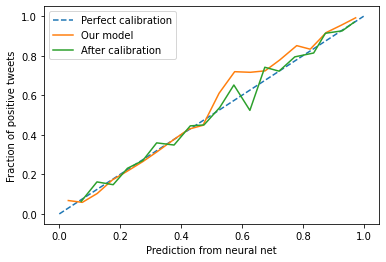

In [ ]:
# We want to interpret the prediction of tweet as probability if the tweet is positive

# Calibration curve compares the prediction with the fraction of true labels being equal to 1
# in ranges (bins) of the prediction

# Example:
# The prediction of a tweet shal be 0.8
# We interpret this prediction as 80% propability that the tweet is positive
# (and as 20% probability that the tweet is negative)
# To ensure that we really can interpret the prediction like that, we compare how many
# tweets are actually positive and negative.
# From 10 tweets with prediction 0.8 we expect 8 to have true label=0 2 to have true label=0


# For the calibration we make a prediction of the previoulsy separated calibration data
y_pred = model.predict(X_calib)
n_bins = 20
y_means, proba_means = calibration_curve(
    y_calib, y_pred, n_bins=n_bins, strategy='uniform')

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
plt.plot(proba_means, y_means, label='Our model')
plt.xlabel('Prediction from neural net')
plt.ylabel('Fraction of positive tweets')
plt.legend()
plt.show()


# The calibration curve already looks well calibrated almost on a 45° line
# However we can slightly improve it with a second model to used for small adjustments
# We will use an isotonic regression model for calibration (postprocessing)
ir = IsotonicRegression()
ir.fit(proba_means.reshape(-1, 1), y_means)
print('-'*15+'Calibration'+'-'*15)
print('Prediction of x_calib before calibration', y_pred[0])

y_pred_calib = ir.transform(y_pred)
print('Prediction of x_calib after calibration', y_pred_calib[0])

y_means_calib, proba_means_calib = calibration_curve(
    y_calib, y_pred_calib, n_bins=n_bins, strategy='uniform')

# Plotting the calibration curve after adjusting the model results
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
plt.plot(proba_means, y_means, label='Our model')
plt.plot(proba_means_calib, y_means_calib, label='After calibration')
plt.xlabel('Prediction from neural net')
plt.ylabel('Fraction of positive tweets')
plt.legend()
plt.show()

In [ ]:
example = ["life is fantastic"]
print('Example text:', example)

# Tokenizing
encoded_docs = tokenizer.texts_to_sequences(example)

# Padding
padded_docs = keras.preprocessing.sequence.pad_sequences(encoded_docs,
                                                         maxlen=max_length, padding='pre')
print('Tokenized and padded sequence:', padded_docs)


# Using the model for sentiment analysis
result = model.predict(padded_docs)
print('Prediction before calibration:', result[0, 0])

# The result will be slightly adjusted using the calibration model
result = ir.transform(result)

print('Prediction after calibration:', result[0])
print()
if result[0] < 0.5:  # 1 positiv, 0 negativ
    print('Tweet is rather negative')
else:
    print('Tweet is rather positive')

Example text: ['life is fantastic']
Tokenized and padded sequence: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  192
     7 1363]]
Prediction before calibration: 0.8896215
Prediction after calibration: 0.9270578007430376

Tweet is rather positive
